In [738]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from indoorplants.analysis import exploratory
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix, \
                            f1_score

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer


from indoorplants.analysis import exploratory
from indoorplants.validation import crossvalidate, curves, boundaries
from indoorplants.analysis import wrangle

import missingno

%matplotlib inline

# 1.0 Exploratory Data Analysis


In [739]:
data_path = os.path.join(os.getcwd(),"home-credit-default-risk")

In [740]:
plt.style.use("seaborn-poster")

In [741]:
def clean_column_names(table):
    table.columns = table.columns.str.replace(r'[^\w\s]','') 
    table.columns = table.columns.str.strip().str.replace(' ','_').str.lower()
    return table

## Reading data

In [742]:
app_train = pd.read_csv(os.path.join(data_path,"application_train.csv"))
bureau_balance = pd.read_csv(os.path.join(data_path,"bureau_balance.csv"))
bureau = pd.read_csv(os.path.join(data_path,"bureau.csv"))
credit_card_balance = pd.read_csv(os.path.join(data_path,"credit_card_balance.csv"))
installments_payments = pd.read_csv(os.path.join(data_path,"installments_payments.csv"))
POS_CASH_balance = pd.read_csv(os.path.join(data_path,"POS_CASH_balance.csv"))
previous_application = pd.read_csv(os.path.join(data_path,"previous_application.csv"))
sample_submission = pd.read_csv(os.path.join(data_path,"sample_submission.csv"))

In [743]:
app_train = clean_column_names(app_train)
bureau_balance = clean_column_names(bureau_balance)
bureau = clean_column_names(bureau)
credit_card_balance = clean_column_names(credit_card_balance)
installments_payments = clean_column_names(installments_payments)
POS_CASH_balance = clean_column_names(POS_CASH_balance)
previous_application = clean_column_names(previous_application)


In [744]:
def get_null_stats(table):
    null_stats = table.isnull().sum().to_frame()
    null_stats = null_stats[(null_stats!=0).all(axis = 1)]
    null_stats.columns = ['num_of_null']
    null_stats['normalize_of_null'] = null_stats['num_of_null']/len(table)
    null_stats = null_stats.sort_values(by='num_of_null',ascending = False)
    return null_stats

In [745]:
def get_null_stats_chart(null_stats_df,name_of_table):
    plt.bar(null_stats_df.index,null_stats_df.normalize_of_null)
    plt.xticks([])
    title = plt.title("{}: Null Stats".format(name_of_table))
    if max(null_stats_df.normalize_of_null) > 0.2:
        plt.axhline(y= 0.2, color='r',linestyle = '--')

In [746]:
tables_name = ['app_train','bureau_balance','bureau','credit_card_balance','installments_payments','POS_CASH_balance']

In [747]:
tables = [app_train,bureau_balance,bureau,credit_card_balance,installments_payments,POS_CASH_balance]

### checking Null Stats

- The graph shows only the features have null values

In [748]:
stats_dfs = []
for table in tables:
    stats_df = get_null_stats(table)
    stats_dfs.append(stats_df)

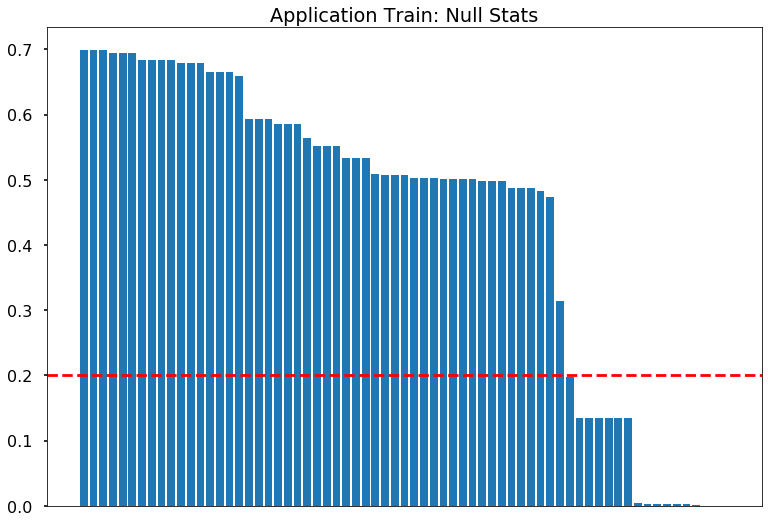

In [749]:
ax= get_null_stats_chart(stats_dfs[0],"Application Train")

In [750]:
print('Table Name:{}'.format(tables_name[1]))
stats_dfs[1]

Table Name:bureau_balance


,num_of_null,normalize_of_null


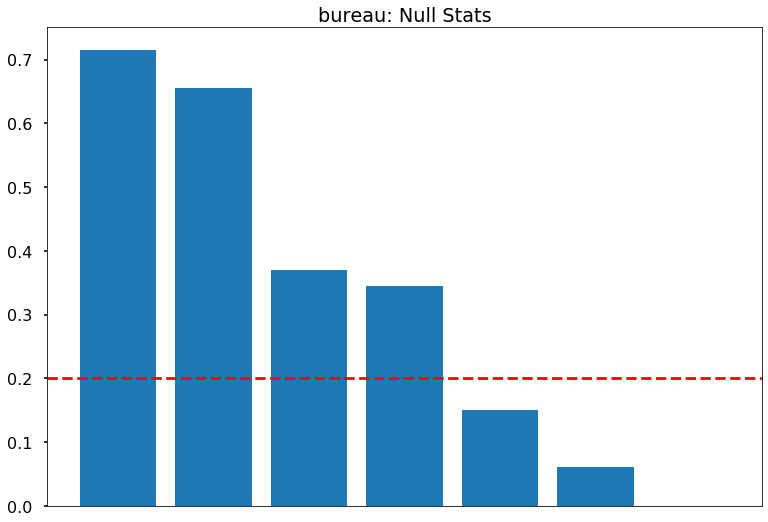

In [751]:
get_null_stats_chart(stats_dfs[2],tables_name[2])

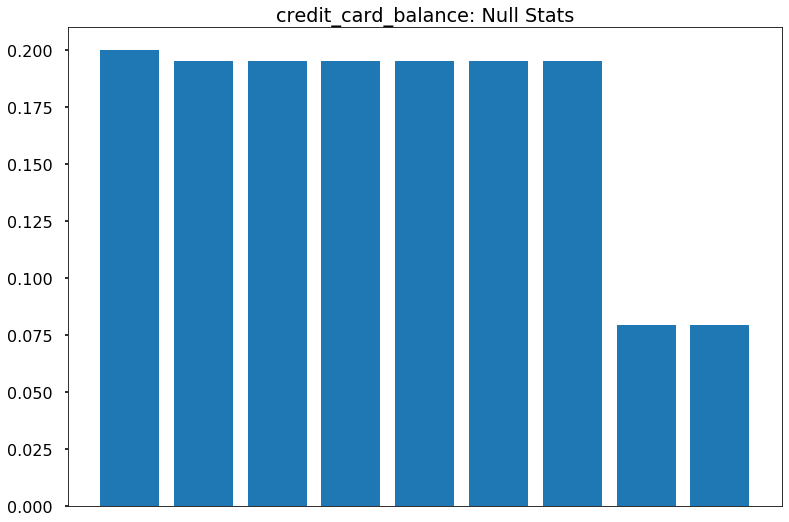

In [752]:
get_null_stats_chart(stats_dfs[3],tables_name[3])

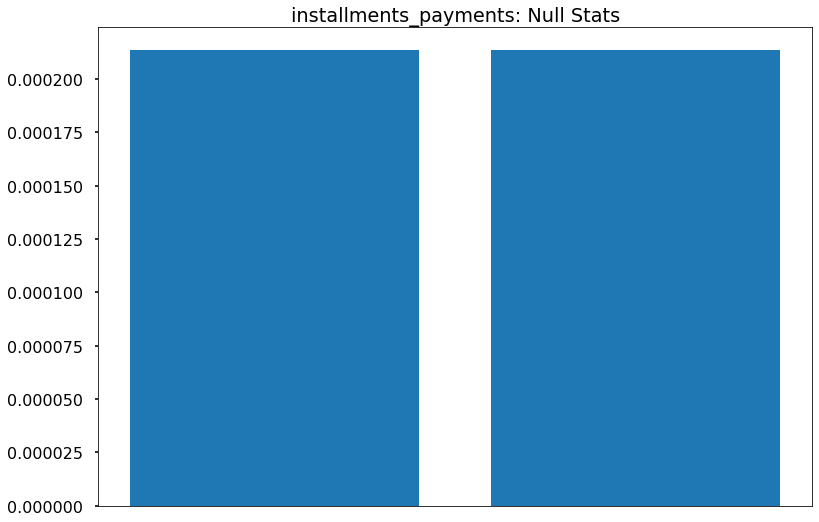

In [753]:
get_null_stats_chart(stats_dfs[4],tables_name[4])

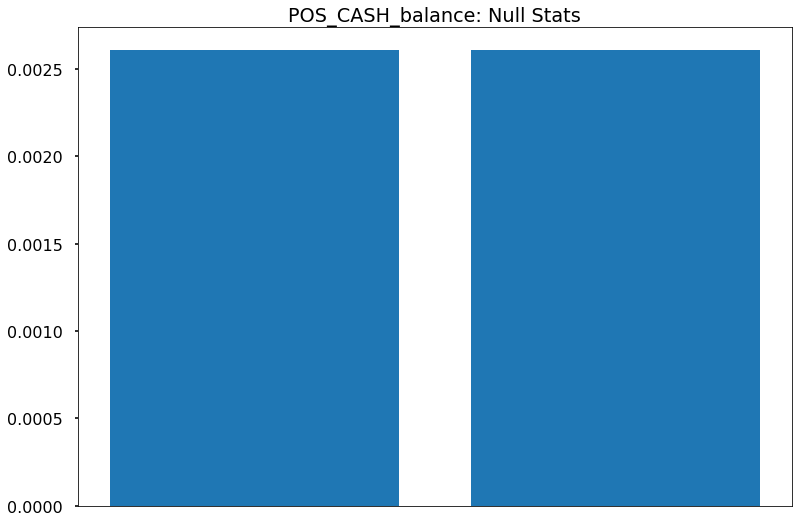

In [754]:
get_null_stats_chart(stats_dfs[5],tables_name[5])

## 1.1 Application_Train
- the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.


- Unique feature: `sk_id_curr`

### 1.1.1 Shape

In [755]:
app_train.shape

(307511, 122)

**Notes:**

There are 121 features in the application training data. 
`target` is the label we want to predict. 

- 1 -  the loan was not repaid
- 0 - the loan was repaid

In [756]:
app_train.target.value_counts()

0    282686
1     24825
Name: target, dtype: int64

In [757]:
app_train.target.value_counts(normalize = True)

0    0.919271
1    0.080729
Name: target, dtype: float64

We can tell that there are around 92% of the examples in the positive class (0) and there are around 8% of examples in the negative class (1).

### 1.1.2 Nulls

In [758]:
null_stats = get_null_stats(table=app_train)
null_stats.head()

,num_of_null,normalize_of_null
commonarea_medi,214865,0.698723
commonarea_avg,214865,0.698723
commonarea_mode,214865,0.698723
nonlivingapartments_medi,213514,0.694330
nonlivingapartments_mode,213514,0.694330


**Notes:**

- I found that there are large amount of information about the clients are null (more than 50%). 
- This could be that the info of clients buildings are hard to get. 

- Therefore, building informations may not be ideal features to predict the default probability.

### 1.1.3 Duplicates

In [759]:
app_train.duplicated().sum()

0

There is NO duplicated examples in the training table.

### 1.1.4 Features

In [760]:
columns_list = app_train.columns.tolist()

In [761]:
columns_type = app_train.dtypes.to_frame()

In [762]:
columns_type.columns = ['data_type']

In [763]:
columns_type.data_type.value_counts()

float64    65
int64      41
object     16
Name: data_type, dtype: int64

Let's particularly take a look at the features with `object` type.

In [764]:
object_columns = columns_type[columns_type.data_type == 'object'].index.tolist()
object_columns

['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'fondkapremont_mode',
 'housetype_mode',
 'wallsmaterial_mode',
 'emergencystate_mode']

In [765]:
# for i in object_columns:
#     print('\n',i,'\n')
#     print(app_train[i].value_counts())

**Notes**
- Interesting information
- We will need to use one hot encoding for modelling later

#### 1.1.4.1 Number of Enquiries to Credit Bureau

In [766]:
bureau_list =[i for i in columns_list if 'bureau' in i]
bureau_list

['amt_req_credit_bureau_hour',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_mon',
 'amt_req_credit_bureau_qrt',
 'amt_req_credit_bureau_year']

**Data Description**
- Number of enquiries to Credit Bureau about the client one hour before application
- Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)
- Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)
- Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)
- Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
- Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)

In [767]:
# for i in bureau_list:
#     print(app_train[i].value_counts())
    

#### 1.1.4.2 Clients' Building Information


**Notes**:

Normalized information about building where the client lives, 
What is average (_AVG suffix), 
modus (_MODE suffix), 
median (_MEDI suffix) 

- apartment size, 
- common area, 
- living area, 
- age of building, 
- number of elevators, 
- number of entrances, 
- state of the building, 
- number of floor

In [768]:
avg_list = [i for i in app_train.columns if 'avg' in i]
avg_list

['apartments_avg',
 'basementarea_avg',
 'years_beginexpluatation_avg',
 'years_build_avg',
 'commonarea_avg',
 'elevators_avg',
 'entrances_avg',
 'floorsmax_avg',
 'floorsmin_avg',
 'landarea_avg',
 'livingapartments_avg',
 'livingarea_avg',
 'nonlivingapartments_avg',
 'nonlivingarea_avg']

In [769]:
mode_list = [i for i in app_train.columns if 'mode' in i]

In [770]:
medi_list = [i for i in app_train.columns if 'medi' in i]

#### 1.1.4.3 clients's personal information 

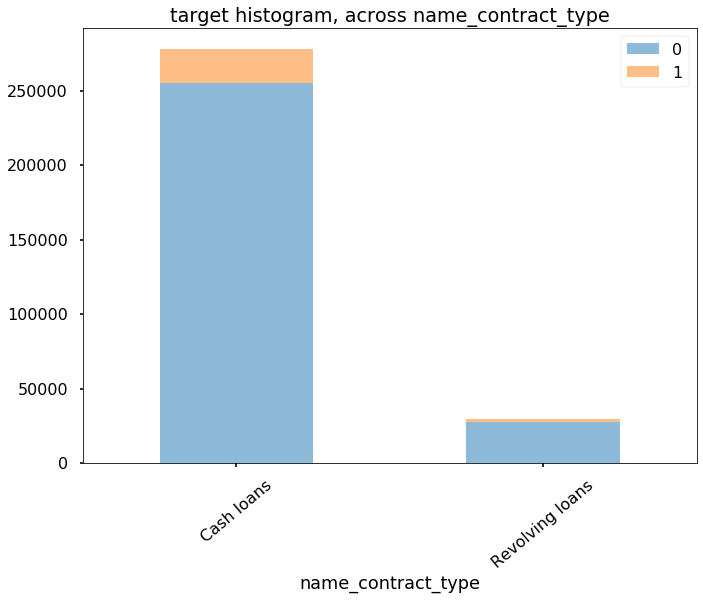

In [771]:
ax = exploratory.feature_value_counts_by_class(app_train, 'target','name_contract_type', rot=40)

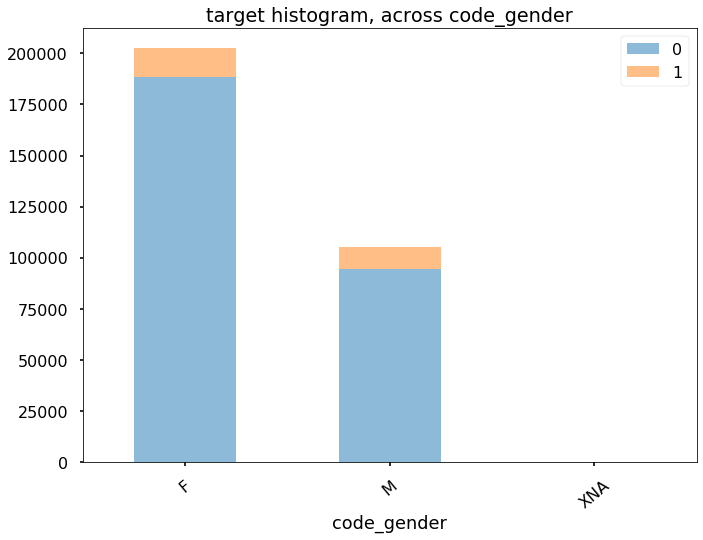

In [772]:
ax = exploratory.feature_value_counts_by_class(app_train, 'target','code_gender', rot=40)

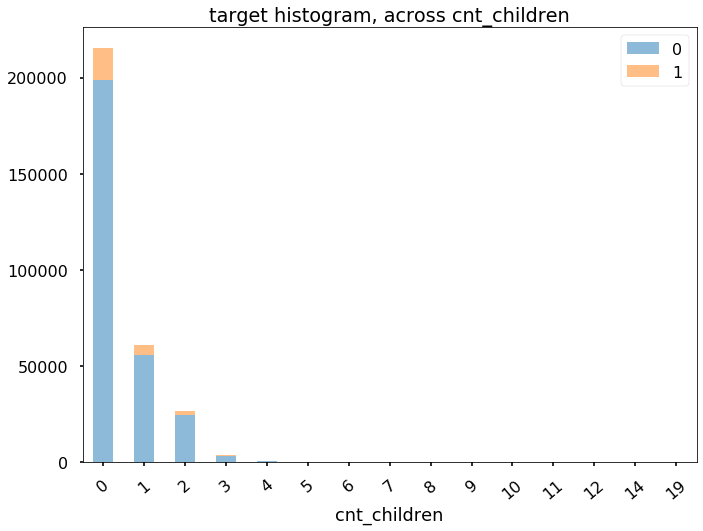

In [773]:
ax = exploratory.feature_value_counts_by_class(app_train, 'target','cnt_children', rot=40)

In [774]:
app_train.amt_income_total.describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: amt_income_total, dtype: float64

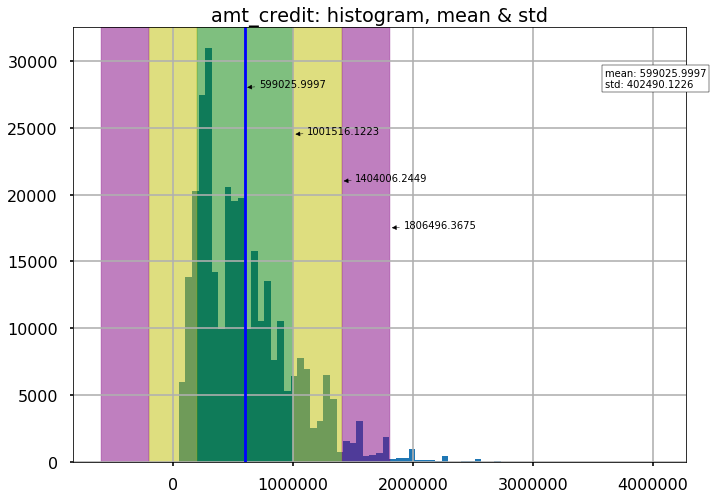

In [775]:
exploratory.center_scale_plot(app_train.amt_credit, np.mean, np.std, bins=73)

In [776]:
app_train.amt_annuity.describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: amt_annuity, dtype: float64

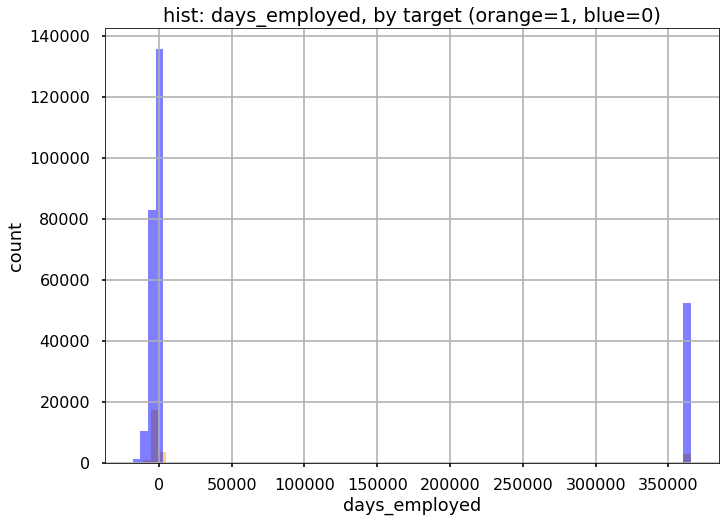

In [777]:
ax =exploratory.feature_hist_by_class(app_train,'target','days_employed',bins=73)

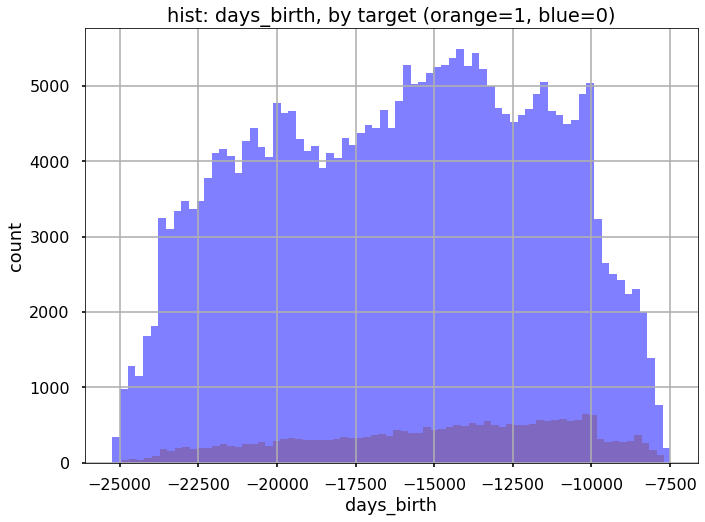

In [778]:
ax = exploratory.feature_hist_by_class(eda_df=app_train, 
                                               class_col= 'target', 
                                               feature = 'days_birth', 
                                               bins=73)

In [779]:
dtype_df = app_train.dtypes.to_frame()
dtype_df.columns = ['dtype']

In [780]:
obj_cols =dtype_df[dtype_df.dtype == 'object'].index.tolist()

In [781]:
num_cols = [col for col in dtype_df.index.tolist() if col not in obj_cols]

In [782]:
one_hot_dfs = []
for col in obj_cols:
    one_hot_dfs.append(pd.get_dummies(app_train[col],prefix=f"is_{col}",drop_first=True))

In [783]:
one_hot = pd.concat(one_hot_dfs, axis=1)

In [784]:
app_train = one_hot.join(app_train[num_cols])

In [785]:
app_train.dtypes.to_frame()[0].value_counts()

uint8      124
float64     65
int64       41
Name: 0, dtype: int64

In [786]:
# col_null = get_null_stats(app_train).index

In [787]:
# for i in col_null:
#     app_train[i] = app_train[i].isnull().astype(int)

In [788]:
# app_train[col_null[2]].value_counts()

In [789]:
x_features = [col for col in app_train.columns if col != 'target']

In [790]:
len(x_features)

229

## 1.2 bureau.csv
- data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.


- Unique feature: `sk_id_bureau`

In [791]:
bureau.shape

(1716428, 17)

In [792]:
bureau.columns

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
       'amt_credit_sum_overdue', 'credit_type', 'days_credit_update',
       'amt_annuity'],
      dtype='object')

In [793]:
bureau.dtypes

sk_id_curr                  int64
sk_id_bureau                int64
credit_active              object
credit_currency            object
days_credit                 int64
credit_day_overdue          int64
days_credit_enddate       float64
days_enddate_fact         float64
amt_credit_max_overdue    float64
cnt_credit_prolong          int64
amt_credit_sum            float64
amt_credit_sum_debt       float64
amt_credit_sum_limit      float64
amt_credit_sum_overdue    float64
credit_type                object
days_credit_update          int64
amt_annuity               float64
dtype: object

In [794]:
bureau.credit_active.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: credit_active, dtype: int64

In [795]:
bureau.credit_currency.value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: credit_currency, dtype: int64

In [796]:
bureau.credit_type.value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: credit_type, dtype: int64

In [797]:
null_stats = get_null_stats(table=bureau)

In [798]:
null_stats

,num_of_null,normalize_of_null
amt_annuity,1226791,0.714735
amt_credit_max_overdue,1124488,0.655133
days_enddate_fact,633653,0.369170
amt_credit_sum_limit,591780,0.344774
amt_credit_sum_debt,257669,0.150119
days_credit_enddate,105553,0.061496
amt_credit_sum,13,0.000008


In [799]:
bureau.duplicated().sum()

0

**Notes:**
- `amt_annuity`,`amt_credit_max_overdue`, `days_enddate_fact` and `amt_credit_sum_limit` have more than 30% of entries are null. 

- There is no duplicated rows in the table `bureau`

- `sk_id_bureau`: Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)


**Data Engineering**
- Apply one hot encoding to _categorical_ columns, `credit_active`,`credit_currency`,`credit_type`
- Deal with `nan` 
- Group table by `sk_id_curr`, mean of _numerical_ features and count of _categorical_ features

In [800]:
bur_obj_cols = ['credit_active','credit_currency','credit_type']
bur_num_cols = [i for i in bureau.columns if i not in bur_obj_cols]

In [801]:
bur_obj_cols

['credit_active', 'credit_currency', 'credit_type']

In [802]:
bur_num_cols

['sk_id_curr',
 'sk_id_bureau',
 'days_credit',
 'credit_day_overdue',
 'days_credit_enddate',
 'days_enddate_fact',
 'amt_credit_max_overdue',
 'cnt_credit_prolong',
 'amt_credit_sum',
 'amt_credit_sum_debt',
 'amt_credit_sum_limit',
 'amt_credit_sum_overdue',
 'days_credit_update',
 'amt_annuity']

In [803]:
bur_one_hot_dfs = []
for col in bur_obj_cols:
    bur_one_hot_dfs.append(pd.get_dummies(bureau[col],prefix=f"is_{col}",drop_first=True))

In [804]:
len(bur_one_hot_dfs)

3

In [805]:
bur_one_hot = pd.concat(bur_one_hot_dfs, axis=1)

In [806]:
bur_one_hot.shape

(1716428, 20)

In [807]:
bureau = bur_one_hot.join(bureau[bur_num_cols])

# bureau.dtypes.to_frame()[0].value_counts()
bureau = clean_column_names(bureau)

In [808]:
bureau.sk_id_bureau.is_unique

True

In [809]:
bureau.sk_id_curr.is_unique

False

## 1.3 bureau_balance.csv
- monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.


- Unique feature: `sk_id_bureau`

In [810]:
bureau_balance.shape

(27299925, 3)

In [811]:
bureau_balance.duplicated().sum()

0

In [812]:
len(bureau_balance.sk_id_bureau.unique())/len(bureau_balance)

0.02994129104750288

In [813]:
null_stats = get_null_stats(table=bureau_balance)
null_stats

,num_of_null,normalize_of_null


**Notes:**
- There is no duplicates or nulls in the `bureau_balance` table


In [814]:
bureau_balance.dtypes

sk_id_bureau       int64
months_balance     int64
status            object
dtype: object

In [815]:
bureau_balance.columns

Index(['sk_id_bureau', 'months_balance', 'status'], dtype='object')

In [816]:
bureau_balance.status.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: status, dtype: int64

In [817]:
num_df = bureau_balance[['sk_id_bureau', 'months_balance']]
num_df.head()

,sk_id_bureau,months_balance
0,5715448,0
1,5715448,-1
2,5715448,-2
3,5715448,-3
4,5715448,-4


In [818]:
one_hot_df = pd.get_dummies(bureau_balance['status'],
                            prefix=f"is_{col}",
                            drop_first=True)

In [819]:
bureau_balance= pd.concat([num_df,one_hot_df],axis=1)

In [820]:
bureau_balance.head()

,sk_id_bureau,months_balance,is_credit_type_1,is_credit_type_2,is_credit_type_3,is_credit_type_4,is_credit_type_5,is_credit_type_C,is_credit_type_X
0,5715448,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,1,0


In [821]:
bureau_balance_num_col = bureau_balance[['sk_id_bureau', 'months_balance']].groupby(['sk_id_bureau']).mean()
bureau_balance_num_col.columns = ['avg_bureau_months_bal']

In [822]:
bureau_balance_cat_col = bureau_balance[['sk_id_bureau', 
                                         'is_credit_type_1', 
                                         'is_credit_type_2', 
                                         'is_credit_type_3', 
                                         'is_credit_type_4', 
                                         'is_credit_type_5', 
                                         'is_credit_type_C', 
                                         'is_credit_type_X']].groupby(['sk_id_bureau']).sum()

In [823]:
bureau_balance = pd.concat([bureau_balance_num_col,bureau_balance_cat_col],axis=1)

In [824]:
bureau_balance.head()

,avg_bureau_months_bal,is_credit_type_1,is_credit_type_2,is_credit_type_3,is_credit_type_4,is_credit_type_5,is_credit_type_C,is_credit_type_X
sk_id_bureau,,,,,,,,
5001709,-48.0,0,0,0,0,0,86,11
5001710,-41.0,0,0,0,0,0,48,30
5001711,-1.5,0,0,0,0,0,0,1
5001712,-9.0,0,0,0,0,0,9,0
5001713,-10.5,0,0,0,0,0,0,22


**Let's join `bureau_balance`  to `bureau` on `sk_id_bureau`**

In [825]:
bureau.sk_id_bureau.count()

1716428

In [826]:
len(bureau_balance.index)

817395

In [827]:
joined = bureau.set_index('sk_id_bureau').join(bureau_balance)

In [828]:
joined_null_stats = get_null_stats(table=joined)

In [829]:
joined_null_stats

,num_of_null,normalize_of_null
amt_annuity,1226791,0.714735
amt_credit_max_overdue,1124488,0.655133
avg_bureau_months_bal,942074,0.548857
is_credit_type_1,942074,0.548857
is_credit_type_2,942074,0.548857
is_credit_type_3,942074,0.548857
is_credit_type_4,942074,0.548857
is_credit_type_5,942074,0.548857
is_credit_type_C,942074,0.548857
is_credit_type_X,942074,0.548857


In [830]:
joined = joined.reset_index()

In [831]:
joined.shape

(1716428, 42)

In [832]:
len(joined.sk_id_bureau.unique())

1716428

In [833]:
len(joined.sk_id_curr.unique())

305811

In [834]:
joined.sk_id_curr.dtypes

dtype('int64')

In [835]:
joined_cat_cols = [i for i in joined.columns if 'is_' in i]

In [836]:
joined_cat_cols.append('sk_id_curr')

In [837]:
joined_num_cols = [i for i in joined.columns if i not in joined_cat_cols]

In [838]:
joined_num_cols.append('sk_id_curr')

In [839]:
joined_num = joined[joined_num_cols].groupby(['sk_id_curr']).mean()

In [840]:
joined_cat = joined[joined_cat_cols].groupby(['sk_id_curr']).sum()

In [841]:
joined_final = pd.concat([joined_num,joined_cat],axis=1)

In [842]:
joined_final.shape

(305811, 41)

In [843]:
joined_final.reset_index(inplace=True)

In [844]:
len([i for i in app_train.sk_id_curr if i in joined_final.sk_id_curr])/len(app_train)

0.577553323295752

In [845]:
app_train.sk_id_curr.dtypes

dtype('int64')

In [846]:
app_train.amt_annuity.dtypes

dtype('float64')

In [847]:
joined_final.sk_id_curr.dtypes

dtype('int64')

In [848]:
joined_final['amt_annuity_2'] = joined_final.amt_annuity


In [849]:
joined_final.drop(columns='amt_annuity',inplace = True)

In [850]:
joined_with_bea_data = app_train.set_index('sk_id_curr').join(joined_final.set_index('sk_id_curr'),how='left')

In [851]:
joined_with_bea_data.shape

(307511, 270)

In [852]:
joined_null_status = get_null_stats(joined_with_bea_data)

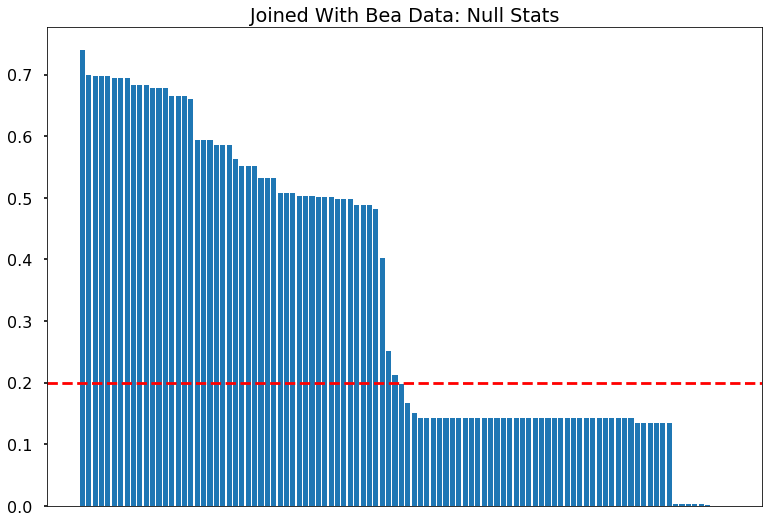

In [853]:
get_null_stats_chart(joined_null_status,'Joined With Bea Data')

In [854]:
joined_null_status[joined_null_status.normalize_of_null>0.4].head()

,num_of_null,normalize_of_null
amt_annuity_2,227502,0.739817
avg_bureau_months_bal,215280,0.700073
commonarea_medi,214865,0.698723
commonarea_mode,214865,0.698723
commonarea_avg,214865,0.698723


**Notes:**
- Shape of joined table (307511, 271)
- After joining _bureau.csv_ and _bureau_balance.csv_ on _application train.csv_, **building** information still on the high(>40%) of null stats. 
- We will leave in this way and using feature selection to select the most important features

## 1.4.1 previous_application.csv

- previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.

In [855]:
previous_application.shape

(1670214, 37)

In [856]:
previous_application.columns

Index(['sk_id_prev', 'sk_id_curr', 'name_contract_type', 'amt_annuity',
       'amt_application', 'amt_credit', 'amt_down_payment', 'amt_goods_price',
       'weekday_appr_process_start', 'hour_appr_process_start',
       'flag_last_appl_per_contract', 'nflag_last_appl_in_day',
       'rate_down_payment', 'rate_interest_primary',
       'rate_interest_privileged', 'name_cash_loan_purpose',
       'name_contract_status', 'days_decision', 'name_payment_type',
       'code_reject_reason', 'name_type_suite', 'name_client_type',
       'name_goods_category', 'name_portfolio', 'name_product_type',
       'channel_type', 'sellerplace_area', 'name_seller_industry',
       'cnt_payment', 'name_yield_group', 'product_combination',
       'days_first_drawing', 'days_first_due', 'days_last_due_1st_version',
       'days_last_due', 'days_termination', 'nflag_insured_on_approval'],
      dtype='object')

In [857]:
len(previous_application.sk_id_prev.unique())

1670214

In [858]:
len(previous_application.sk_id_curr.unique())/len(previous_application.sk_id_prev.unique())

0.20288238513148615

In [859]:
previous_application_dtypes = previous_application.dtypes.to_frame()
previous_application_dtypes.columns = ['types']

In [860]:
cat_cols = previous_application_dtypes[previous_application_dtypes['types'] == 'object'].index.tolist()

In [861]:
cat_cols.append('hour_appr_process_start')
cat_cols.append('nflag_insured_on_approval')

In [862]:
cat_cols.append('nflag_last_appl_in_day')

In [863]:
for i in cat_cols:
    print(previous_application[i].value_counts(),'\n')

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: name_contract_type, dtype: int64 

TUESDAY      255118
WEDNESDAY    255010
MONDAY       253557
FRIDAY       252048
THURSDAY     249099
SATURDAY     240631
SUNDAY       164751
Name: weekday_appr_process_start, dtype: int64 

Y    1661739
N       8475
Name: flag_last_appl_per_contract, dtype: int64 

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car               

In [864]:
def get_one_hot_df(dataframe,num_cols,obj_cols,drop_first=True):
    one_hot_dfs = []
    for col in obj_cols:
        one_hot_dfs.append(pd.get_dummies(dataframe[col],prefix=f"is_{col}",drop_first=drop_first))
        
    one_hot = pd.concat(one_hot_dfs, axis=1)
    dataframe = one_hot.join(dataframe[num_cols])
    return dataframe

In [865]:
num_cols = [col for col in previous_application_dtypes.index.tolist() if col not in cat_cols]

In [866]:
num_cols

['sk_id_prev',
 'sk_id_curr',
 'amt_annuity',
 'amt_application',
 'amt_credit',
 'amt_down_payment',
 'amt_goods_price',
 'rate_down_payment',
 'rate_interest_primary',
 'rate_interest_privileged',
 'days_decision',
 'sellerplace_area',
 'cnt_payment',
 'days_first_drawing',
 'days_first_due',
 'days_last_due_1st_version',
 'days_last_due',
 'days_termination']

In [867]:
previous_application_one_hot = get_one_hot_df(dataframe=previous_application,
                                              num_cols=num_cols,
                                              obj_cols=cat_cols,
                                              drop_first=False)

In [868]:
previous_application_one_hot = clean_column_names(previous_application_one_hot)

In [869]:
previous_application_one_hot= previous_application_one_hot.drop(columns=['sk_id_prev'])

In [870]:
[i for i in previous_application_one_hot.columns if 'sk_' in i]

['sk_id_curr']

**Notes:**
- After applying one hot to _previous application.csv_, I will start to group the table by `sk_id_curr`. 
- One `sk_id_curr` has may `sk_id_prev` records. For categorical variables, I will simply count the ones in the features

In [871]:
one_hot_cat_cols = [i for i in previous_application_one_hot.columns if 'is_' in i]

In [872]:
one_hot_cat_cols.append('sk_id_curr')

In [873]:
grouped_cat = previous_application_one_hot[one_hot_cat_cols].groupby(['sk_id_curr']).sum()

In [874]:
one_hot_num_cols = [i for i in previous_application_one_hot.columns if i not in one_hot_cat_cols]

In [875]:
one_hot_num_cols.append('sk_id_curr')

In [876]:
one_hot_num_cols

['amt_annuity',
 'amt_application',
 'amt_credit',
 'amt_down_payment',
 'amt_goods_price',
 'rate_down_payment',
 'rate_interest_primary',
 'rate_interest_privileged',
 'days_decision',
 'sellerplace_area',
 'cnt_payment',
 'days_first_drawing',
 'days_first_due',
 'days_last_due_1st_version',
 'days_last_due',
 'days_termination',
 'sk_id_curr']

**Notes:**
- For the _amt_ variables, I will take the avg
- for the _rates_ variables, I will take the avg
- for the _days_ variables, I will take the avg
- dropping `sellerplace_area` at the moment

In [877]:
one_hot_num_cols.remove('sellerplace_area')

In [878]:
amt_cols = [i for i in one_hot_num_cols if 'amt_' in i] +['cnt_payment','sk_id_curr']
rates_cols = [i for i in one_hot_num_cols if 'rate_' in i]+['sk_id_curr']
days_cols = [i for i in one_hot_num_cols if 'days_' in i]+['sk_id_curr']

In [879]:
amt_cols_2 = [i for i in one_hot_num_cols if 'amt_' in i] +['cnt_payment']
clean_cols = []
for col in amt_cols_2:
    clean_cols.append(f"avg_pre_app_{col}")

res_dict = dict(zip(amt_cols_2, clean_cols)) 

In [880]:
grouped_amt =  previous_application_one_hot[amt_cols].groupby(['sk_id_curr']).mean()
grouped_amt= grouped_amt.rename(columns =res_dict)

In [881]:
rates_cols_2 = [i for i in one_hot_num_cols if 'rate_' in i]
clean_cols = []
for col in rates_cols_2:
    clean_cols.append(f"avg_pre_app_{col}")

res_dict = dict(zip(rates_cols_2, clean_cols)) 

In [882]:
grouped_rate =  previous_application_one_hot[rates_cols].groupby(['sk_id_curr']).mean()
grouped_rate= grouped_rate.rename(columns =res_dict)

In [883]:
days_cols_2 = [i for i in one_hot_num_cols if 'days_' in i]
clean_cols = []
for col in days_cols_2:
    clean_cols.append(f"avg_pre_app_{col}")

res_dict = dict(zip(days_cols_2, clean_cols)) 

In [884]:
grouped_days =  previous_application_one_hot[days_cols].groupby(['sk_id_curr']).mean()
grouped_days= grouped_days.rename(columns =res_dict)

In [885]:
grouped_prev_app = grouped_amt.join(grouped_cat).join(grouped_days).join(grouped_rate).reset_index()

In [886]:
grouped_prev_app.head()

,sk_id_curr,avg_pre_app_amt_annuity,avg_pre_app_amt_application,avg_pre_app_amt_credit,avg_pre_app_amt_down_payment,avg_pre_app_amt_goods_price,avg_pre_app_cnt_payment,is_name_contract_type_cash_loans,is_name_contract_type_consumer_loans,is_name_contract_type_revolving_loans,...,is_nflag_last_appl_in_day_1,avg_pre_app_days_decision,avg_pre_app_days_first_drawing,avg_pre_app_days_first_due,avg_pre_app_days_last_due_1st_version,avg_pre_app_days_last_due,avg_pre_app_days_termination,avg_pre_app_rate_down_payment,avg_pre_app_rate_interest_primary,avg_pre_app_rate_interest_privileged
0,100001,3951.000,24835.50,23787.00,2520.0,24835.5,8.0,0,1,0,...,1,-1740.0,365243.0,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.104326,NaN,NaN
1,100002,9251.775,179055.00,179055.00,0.0,179055.0,24.0,0,1,0,...,1,-606.0,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000,NaN,NaN
2,100003,56553.990,435436.50,484191.00,3442.5,435436.5,10.0,1,2,0,...,3,-1305.0,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.050030,NaN,NaN
3,100004,5357.250,24282.00,20106.00,4860.0,24282.0,4.0,0,1,0,...,1,-815.0,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.212008,NaN,NaN
4,100005,4813.200,22308.75,20076.75,4464.0,44617.5,12.0,1,1,0,...,2,-536.0,365243.0,-706.000000,-376.000000,-466.000000,-460.000000,0.108964,NaN,NaN


## 1.4.2 credit_card_balance.csv
- monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

- `SK_ID_PREV` 	ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- `SK_ID_CURR`	ID of loan in our sample

- `MONTHS_BALANCE`	Month of balance relative to application date (-1 means the freshest balance date)
- `AMT_BALANCE`	Balance during the month of previous credit
- `AMT_CREDIT_LIMIT_ACTUAL`	Credit card limit during the month of the previous credit
- `AMT_DRAWINGS_ATM_CURRENT`	Amount drawing at ATM during the month of the previous credit
- `AMT_DRAWINGS_CURRENT`	Amount drawing during the month of the previous credit
- `AMT_DRAWINGS_OTHER_CURRENT`	Amount of other drawings during the month of the previous credit
- `AMT_DRAWINGS_POS_CURRENT`	Amount drawing or buying goods during the month of the previous credit
- `AMT_INST_MIN_REGULARITY`	Minimal installment for this month of the previous credit
- `AMT_PAYMENT_CURRENT`	How much did the client pay during the month on the previous credit
- `AMT_PAYMENT_TOTAL_CURRENT`	How much did the client pay during the month in total on the previous credit
- `AMT_RECEIVABLE_PRINCIPAL`	Amount receivable for principal on the previous credit
- `AMT_RECIVABLE`	Amount receivable on the previous credit
- `AMT_TOTAL_RECEIVABLE`	Total amount receivable on the previous credit
- `CNT_DRAWINGS_ATM_CURRENT`	Number of drawings at ATM during this month on the previous credit
- `CNT_DRAWINGS_CURRENT`	Number of drawings during this month on the previous credit
- `CNT_DRAWINGS_OTHER_CURRENT`	Number of other drawings during this month on the previous credit
- `CNT_DRAWINGS_POS_CURRENT`	Number of drawings for goods during this month on the previous credit
- `CNT_INSTALMENT_MATURE_CUM`	Number of paid installments on the previous credit
- `NAME_CONTRACT_STATUS`	Contract status (active signed,...) on the previous credit
- `SK_DPD`	DPD (Days past due) during the month on the previous credit (_avg_)
- `SK_DPD_DEF`	DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit (avg_)

In [887]:
credit_card_balance.shape

(3840312, 23)

In [888]:
credit_card_balance.duplicated().sum()

0

In [889]:
credit_card_balance.columns

Index(['sk_id_prev', 'sk_id_curr', 'months_balance', 'amt_balance',
       'amt_credit_limit_actual', 'amt_drawings_atm_current',
       'amt_drawings_current', 'amt_drawings_other_current',
       'amt_drawings_pos_current', 'amt_inst_min_regularity',
       'amt_payment_current', 'amt_payment_total_current',
       'amt_receivable_principal', 'amt_recivable', 'amt_total_receivable',
       'cnt_drawings_atm_current', 'cnt_drawings_current',
       'cnt_drawings_other_current', 'cnt_drawings_pos_current',
       'cnt_instalment_mature_cum', 'name_contract_status', 'sk_dpd',
       'sk_dpd_def'],
      dtype='object')

In [890]:
credit_card_balance.head()

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,...,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [891]:
credit_card_balance.dtypes

sk_id_prev                      int64
sk_id_curr                      int64
months_balance                  int64
amt_balance                   float64
amt_credit_limit_actual         int64
amt_drawings_atm_current      float64
amt_drawings_current          float64
amt_drawings_other_current    float64
amt_drawings_pos_current      float64
amt_inst_min_regularity       float64
amt_payment_current           float64
amt_payment_total_current     float64
amt_receivable_principal      float64
amt_recivable                 float64
amt_total_receivable          float64
cnt_drawings_atm_current      float64
cnt_drawings_current            int64
cnt_drawings_other_current    float64
cnt_drawings_pos_current      float64
cnt_instalment_mature_cum     float64
name_contract_status           object
sk_dpd                          int64
sk_dpd_def                      int64
dtype: object

In [892]:
one_hot = pd.get_dummies(data=credit_card_balance['name_contract_status'],drop_first=True,prefix=f"is_{col}")

In [893]:
credit_card_balance = pd.concat([credit_card_balance,one_hot],axis=1)

In [894]:
credit_card_balance= credit_card_balance.drop(columns='name_contract_status')

In [895]:
len(credit_card_balance.sk_id_prev.unique())

104307

In [896]:
len(credit_card_balance.sk_id_curr.unique())

103558

**Notes:**
- One `sk_id_curr` has many `sk_id_prev`

In [897]:
get_null_stats(credit_card_balance)

,num_of_null,normalize_of_null
amt_payment_current,767988,0.199981
amt_drawings_atm_current,749816,0.195249
amt_drawings_other_current,749816,0.195249
amt_drawings_pos_current,749816,0.195249
cnt_drawings_atm_current,749816,0.195249
cnt_drawings_other_current,749816,0.195249
cnt_drawings_pos_current,749816,0.195249
amt_inst_min_regularity,305236,0.079482
cnt_instalment_mature_cum,305236,0.079482


In [898]:
credit_card_balance.shape

(3840312, 28)

In [899]:
credit_card_balance= credit_card_balance.drop(columns = 'sk_id_prev')

In [900]:
cre_card_bal_cols = credit_card_balance.columns.tolist()
cre_card_bal_cols

['sk_id_curr',
 'months_balance',
 'amt_balance',
 'amt_credit_limit_actual',
 'amt_drawings_atm_current',
 'amt_drawings_current',
 'amt_drawings_other_current',
 'amt_drawings_pos_current',
 'amt_inst_min_regularity',
 'amt_payment_current',
 'amt_payment_total_current',
 'amt_receivable_principal',
 'amt_recivable',
 'amt_total_receivable',
 'cnt_drawings_atm_current',
 'cnt_drawings_current',
 'cnt_drawings_other_current',
 'cnt_drawings_pos_current',
 'cnt_instalment_mature_cum',
 'sk_dpd',
 'sk_dpd_def',
 'is_days_termination_Approved',
 'is_days_termination_Completed',
 'is_days_termination_Demand',
 'is_days_termination_Refused',
 'is_days_termination_Sent proposal',
 'is_days_termination_Signed']

In [901]:
num_cols = [i for i in cre_card_bal_cols if 'is_' not in i]
num_cols

['sk_id_curr',
 'months_balance',
 'amt_balance',
 'amt_credit_limit_actual',
 'amt_drawings_atm_current',
 'amt_drawings_current',
 'amt_drawings_other_current',
 'amt_drawings_pos_current',
 'amt_inst_min_regularity',
 'amt_payment_current',
 'amt_payment_total_current',
 'amt_receivable_principal',
 'amt_recivable',
 'amt_total_receivable',
 'cnt_drawings_atm_current',
 'cnt_drawings_current',
 'cnt_drawings_other_current',
 'cnt_drawings_pos_current',
 'cnt_instalment_mature_cum',
 'sk_dpd',
 'sk_dpd_def']

In [902]:
num_cols_2= [i for i in cre_card_bal_cols if 'is_' not in i]
num_cols_2.remove('sk_id_curr') 
clean_cols = []
for col in num_cols_2:
    clean_cols.append(f"avg_cre_bal_{col}")

res_dict = dict(zip(num_cols_2, clean_cols)) 

In [903]:
grouped_num = credit_card_balance[num_cols].groupby(['sk_id_curr']).mean()

In [904]:
grouped_num = grouped_num.rename(columns=res_dict)

In [905]:
grouped_num.columns

Index(['avg_cre_bal_months_balance', 'avg_cre_bal_amt_balance',
       'avg_cre_bal_amt_credit_limit_actual',
       'avg_cre_bal_amt_drawings_atm_current',
       'avg_cre_bal_amt_drawings_current',
       'avg_cre_bal_amt_drawings_other_current',
       'avg_cre_bal_amt_drawings_pos_current',
       'avg_cre_bal_amt_inst_min_regularity',
       'avg_cre_bal_amt_payment_current',
       'avg_cre_bal_amt_payment_total_current',
       'avg_cre_bal_amt_receivable_principal', 'avg_cre_bal_amt_recivable',
       'avg_cre_bal_amt_total_receivable',
       'avg_cre_bal_cnt_drawings_atm_current',
       'avg_cre_bal_cnt_drawings_current',
       'avg_cre_bal_cnt_drawings_other_current',
       'avg_cre_bal_cnt_drawings_pos_current',
       'avg_cre_bal_cnt_instalment_mature_cum', 'avg_cre_bal_sk_dpd',
       'avg_cre_bal_sk_dpd_def'],
      dtype='object')

In [906]:
cat_cols = [i for i in cre_card_bal_cols if 'is_' in i]

In [907]:
cat_cols

['is_days_termination_Approved',
 'is_days_termination_Completed',
 'is_days_termination_Demand',
 'is_days_termination_Refused',
 'is_days_termination_Sent proposal',
 'is_days_termination_Signed']

In [908]:
cat_cols.append('sk_id_curr')

In [909]:
grouped_cat = credit_card_balance[cat_cols].groupby(['sk_id_curr']).mean()

In [910]:
grouped_credit_card_balance = grouped_num.join(grouped_cat)

In [911]:
joined_credit_bal= grouped_credit_card_balance.join(grouped_prev_app.set_index('sk_id_curr'))

In [912]:
joined_credit_bal.shape

(103558, 212)

In [913]:
null_stats= get_null_stats(joined_credit_bal)

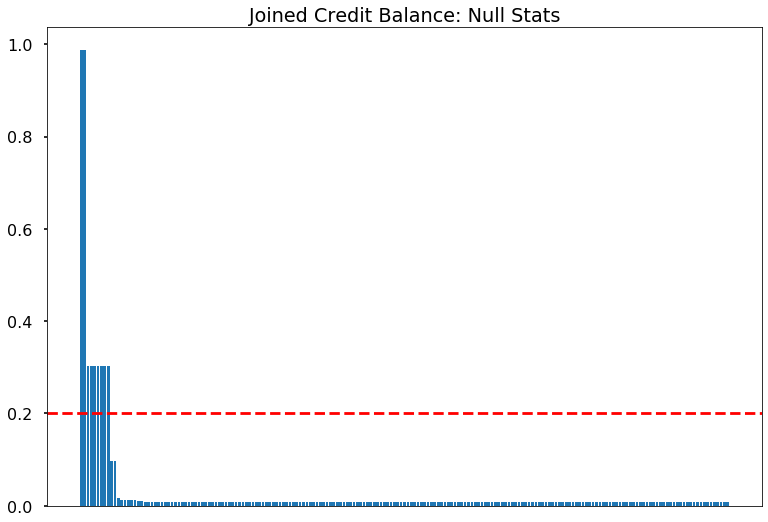

In [914]:
get_null_stats_chart(null_stats,'Joined Credit Balance')

In [915]:
# joined_credit_bal['months_balance_2'] = joined_credit_bal['months_balance']

In [916]:
# joined_credit_bal = joined_credit_bal.drop(columns='months_balance')

In [917]:
joined_final = joined_final.set_index('sk_id_curr').join(joined_credit_bal)

In [918]:
joined_final.shape

(305811, 253)

In [919]:
joined_final_null_stats = get_null_stats(joined_final)

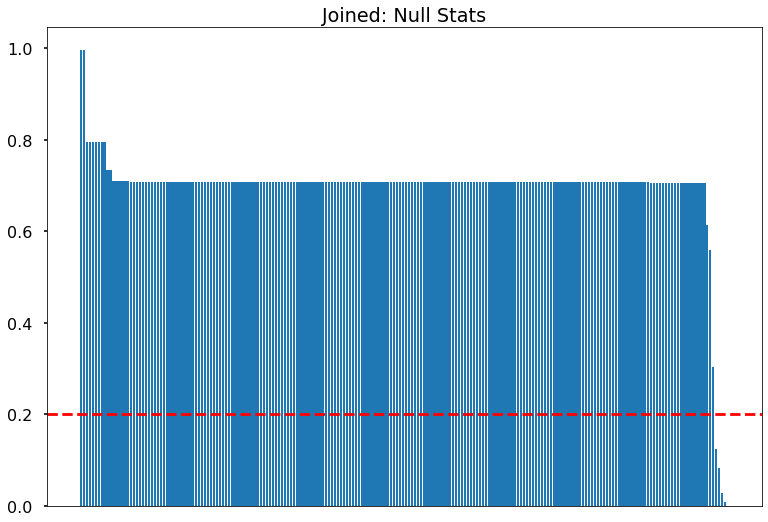

In [920]:
get_null_stats_chart(joined_final_null_stats,'Joined')

## 1.5 installments_payments.csv

- payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.


In [921]:
installments_payments.head()

,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [922]:
installments_payments.dtypes

sk_id_prev                  int64
sk_id_curr                  int64
num_instalment_version    float64
num_instalment_number       int64
days_instalment           float64
days_entry_payment        float64
amt_instalment            float64
amt_payment               float64
dtype: object

In [923]:
installments_payments.sk_id_curr.nunique()

339587

In [924]:
installments_payments.sk_id_prev.nunique()

997752

In [925]:
installments_payments.shape

(13605401, 8)

**Notes**
- Not counting num_cols 

In [926]:
days_cols = ['days_instalment','days_entry_payment','sk_id_curr']

In [927]:
amt_cols = ['amt_instalment','amt_payment','sk_id_curr']

In [928]:
joined_install_pmt= installments_payments[days_cols
                                         ].groupby(['sk_id_curr']).mean(
            ).join(installments_payments[
                                          amt_cols].groupby(['sk_id_curr']).sum())


In [929]:
joined_install_pmt.shape

(339587, 4)

In [930]:
joined_final_2= joined_install_pmt.join(joined_final)

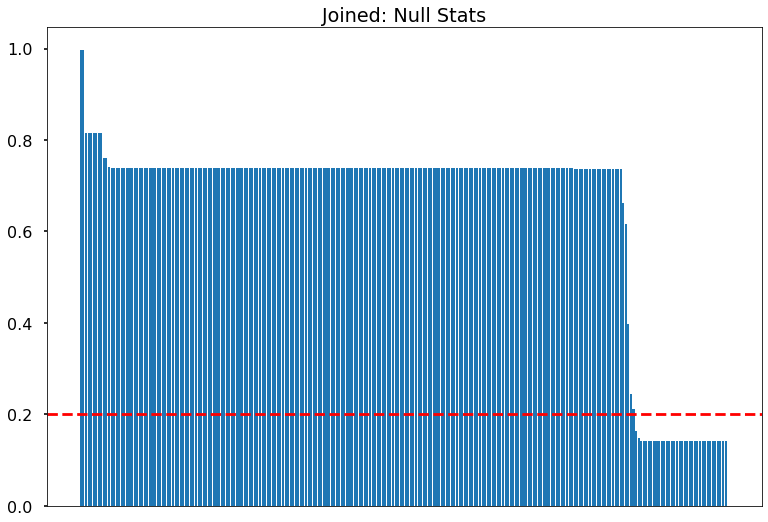

In [931]:
null_stats = get_null_stats(joined_final_2)
get_null_stats_chart(null_stats,'Joined')

## 1.6 POS_CASH_balance.csv
- monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

In [1029]:
POS_CASH_balance.shape

(10001358, 8)

In [932]:
POS_CASH_balance.head()

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [933]:
POS_CASH_balance.dtypes

sk_id_prev                 int64
sk_id_curr                 int64
months_balance             int64
cnt_instalment           float64
cnt_instalment_future    float64
name_contract_status      object
sk_dpd                     int64
sk_dpd_def                 int64
dtype: object

- `SK_ID_PREV` 	ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)
- `SK_ID_CURR`	ID of loan in our sample
- `MONTHS_BALANCE`	Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly ) (_avg_)
- `CNT_INSTALMENT`	Term of previous credit (can change over time) (_avg_)
- `CNT_INSTALMENT_FUTURE`	Installments left to pay on the previous credit(_avg_)
- `NAME_CONTRACT_STATUS`	Contract status during the month (_sum_)
- `SK_DPD`	DPD (days past due) during the month of previous credit (_avg_)
- `SK_DPD_DEF`	DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit! (_avg_)

In [934]:
POS_CASH_balance.name_contract_status.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: name_contract_status, dtype: int64

In [935]:
num_cols = [i for i in POS_CASH_balance.columns if i not in ['name_contract_status']]
obj_cols = ['name_contract_status']

In [936]:
POS_CASH_balance_one_hot =get_one_hot_df(
                                dataframe=POS_CASH_balance,
                                num_cols=num_cols,
                                obj_cols=obj_cols,
                                drop_first=True)

In [937]:
obj_one_hot = [i for i in POS_CASH_balance_one_hot.columns if 'is_' in i]

In [938]:
obj_one_hot.append('sk_id_curr')

In [939]:
POS_CASH_balance_one_hot.sk_id_curr.nunique()

337252

In [940]:
POS_CASH_balance_one_hot.sk_id_prev.nunique()

936325

In [941]:
grouped_pos_num = POS_CASH_balance_one_hot[num_cols].groupby(['sk_id_curr']).mean()

In [942]:
grouped_pos_cat = POS_CASH_balance_one_hot[obj_one_hot].groupby(['sk_id_curr']).sum()

In [943]:
joined_pos = grouped_pos_num.join(grouped_pos_cat)

In [944]:
joined_pos= joined_pos.drop(columns=['sk_id_prev'])

In [945]:
joined_pos= joined_pos.rename(columns={"months_balance": "pre_avg_months_balance", 
                                       "sk_dpd": "pre_avg_sk_dpd",
                                       "sk_dpd_def":"pre_avg_sk_dpd_def"})

In [946]:
joined_pos.columns

Index(['pre_avg_months_balance', 'cnt_instalment', 'cnt_instalment_future',
       'pre_avg_sk_dpd', 'pre_avg_sk_dpd_def',
       'is_name_contract_status_Amortized debt',
       'is_name_contract_status_Approved', 'is_name_contract_status_Canceled',
       'is_name_contract_status_Completed', 'is_name_contract_status_Demand',
       'is_name_contract_status_Returned to the store',
       'is_name_contract_status_Signed', 'is_name_contract_status_XNA'],
      dtype='object')

In [947]:
joined_final_2.shape

(339587, 257)

In [948]:
joined_pos.shape

(337252, 13)

In [949]:
joined_final_3= joined_final_2.join(joined_pos)

In [950]:
null_stats = get_null_stats(joined_final_3)

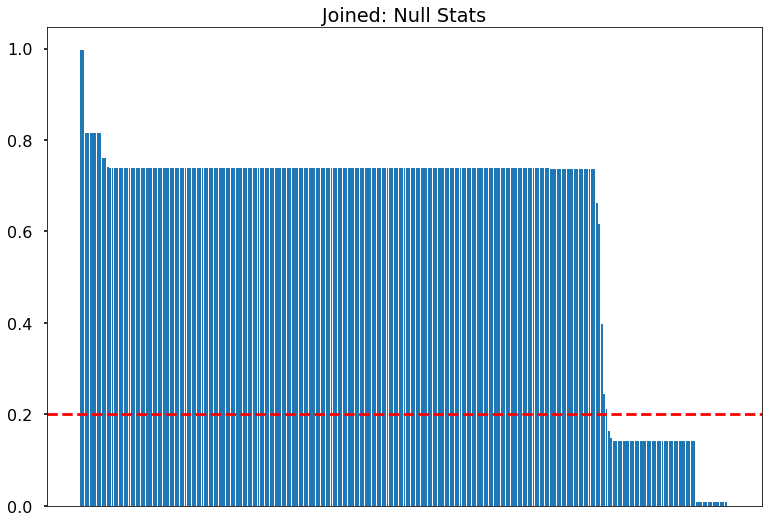

In [951]:
get_null_stats_chart(null_stats,'Joined')

In [952]:
joined_final_3.shape

(339587, 270)

In [953]:
dup_cols=[i for i in joined_final_3.columns if i in joined_with_bea_data]
dup_cat_col = [i for i in dup_cols if 'is_' in i]

In [954]:
clean_cols = []
for col in dup_cols:
    clean_cols.append(f"pre_{col}")

In [955]:
res_dict = dict(zip(dup_cols, clean_cols)) 

In [956]:
joined_final_3 = joined_final_3.rename(columns=res_dict)

In [957]:
joined_final_3.shape

(339587, 270)

In [958]:
table_to_model = joined_with_bea_data.join(joined_final_3)

In [959]:
table_to_model.shape

(307511, 540)

In [960]:
null_stats=get_null_stats(table_to_model)

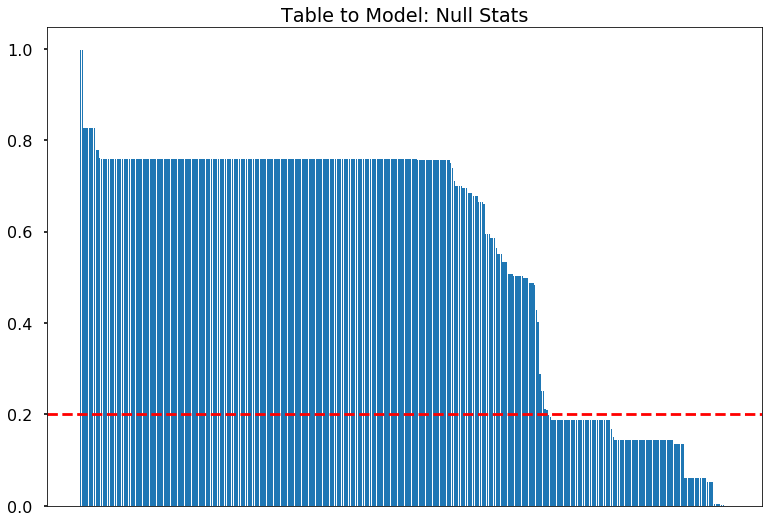

In [961]:
get_null_stats_chart(null_stats, 'Table to Model')

In [962]:
cols= table_to_model.columns

Droping features have more than 20% nullsm

In [963]:
null_stats.iloc[1]['normalize_of_null']

0.9968488932103242

In [964]:
over_20_null_cols = [i for c,i in enumerate(null_stats.index) if null_stats.iloc[c]['normalize_of_null'] > 0.2]

In [965]:
table_to_model= table_to_model.drop(columns=over_20_null_cols)

In [966]:
table_to_model.shape

(307511, 272)

In [967]:
[i for i in table_to_model.columns if 'sk_' in i]

['sk_id_bureau', 'pre_sk_id_bureau', 'pre_avg_sk_dpd', 'pre_avg_sk_dpd_def']

## Final join

# 2. Feature Selection 

## Dealing with missing values

In [968]:
table_to_model= table_to_model.drop(columns=['sk_id_bureau','pre_sk_id_bureau'])

In [969]:
get_null_stats(table_to_model).head()

,num_of_null,normalize_of_null
ext_source_3,60965,0.198253
pre_days_credit_enddate,59586,0.193769
pre_amt_credit_sum,57509,0.187014
pre_cnt_credit_prolong,57508,0.187011
pre_is_credit_currency_currency_2,57508,0.187011


In [970]:
cat_cols = [i for i in table_to_model.columns if 'is_' in i]

In [971]:
len(cat_cols)

186

In [972]:
num_cols = [i for i in table_to_model.columns if i not in cat_cols]

## Imputing numerical features

In [973]:
table_to_model[num_cols] = Imputer(strategy='mean').fit_transform(table_to_model[num_cols])

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Imputing categorical features

In [974]:
table_to_model[cat_cols] = table_to_model[cat_cols].fillna(0)

In [975]:
get_null_stats(table_to_model)

,num_of_null,normalize_of_null


## let's do some feature selection

In [1001]:
table_to_model = clean_column_names(table_to_model)

In [1002]:
y = table_to_model.target 

In [1003]:
X = table_to_model.drop(columns=['target'])

In [1004]:
feature_name = X.columns.tolist()

In [1005]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [1006]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


## Random Forest Classifier

In [981]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [982]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

120 selected features


## Chi

In [983]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x1483005f0>)

In [984]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


In [985]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## RFE

In [986]:
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 269 features.
Fitting estimator with 259 features.
Fitting estimator with 249 features.
Fitting estimator with 239 features.
Fitting estimator with 229 features.
Fitting estimator with 219 features.
Fitting estimator with 209 features.
Fitting estimator with 199 features.
Fitting estimator with 189 features.
Fitting estimator with 179 features.
Fitting estimator with 169 features.
Fitting estimator with 159 features.
Fitting estimator with 149 features.
Fitting estimator with 139 features.
Fitting estimator with 129 features.
Fitting estimator with 119 features.
Fitting estimator with 109 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=100, step=10, verbose=5)

In [987]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


## Logistic Regression

In [988]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='warn',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='warn',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False,
                threshold='1.25*median')

In [989]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

128 selected features


## LGBM

In [991]:
X = clean_column_names(X)

In [992]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=None, norm_order=1, prefit=False

In [993]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

122 selected features


In [1007]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)


In [1008]:
len(feature_selection_df[feature_selection_df.Total > 2])

122

In [1009]:
feature_selection_df.loc[:136]

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,region_rating_client_w_city,True,True,True,True,True,True,6
2,pre_is_credit_type_credit_card,True,True,True,True,True,True,6
3,pre_is_credit_type_car_loan,True,True,True,True,True,True,6
4,pre_is_credit_active_closed,True,True,True,True,True,True,6
5,pre_avg_months_balance,True,True,True,True,True,True,6
6,is_name_education_type_secondary__secondary_sp...,True,True,True,True,True,True,6
7,is_credit_type_microloan,True,True,True,True,True,True,6
8,is_credit_type_car_loan,True,True,True,True,True,True,6
9,is_credit_active_closed,True,True,True,True,True,True,6
10,is_code_gender_m,True,True,True,True,True,True,6


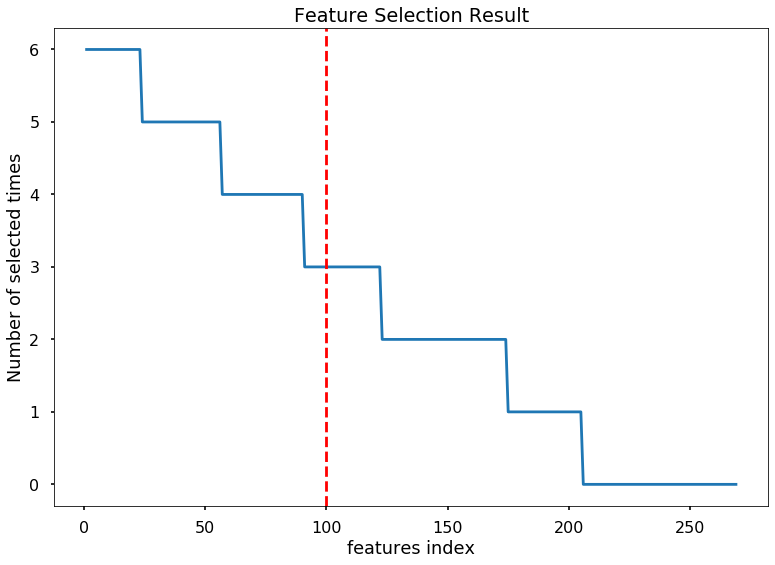

In [1010]:
fig,ax = plt.subplots()
ax.plot(feature_selection_df.index,feature_selection_df.Total)
ax.set_title('Feature Selection Result')
ax.set_ylabel('Number of selected times')
ax.set_xlabel('features index')
ax.axvline(x= 100, color='r',linestyle = '--')

In [1011]:
selected_features = feature_selection_df.Feature.tolist()[:122]

In [1012]:
selected_features[:5]

['region_rating_client_w_city',
 'pre_is_credit_type_credit_card',
 'pre_is_credit_type_car_loan',
 'pre_is_credit_active_closed',
 'pre_avg_months_balance']

# 3. Modelling

## testing

In [1013]:
for_modeling = X[selected_features]

In [1014]:
for_modeling= pd.concat([for_modeling,y],axis = 1)

In [1015]:
for_modeling.shape

(307511, 123)

In [1016]:
cv, final = train_test_split(for_modeling.index, test_size=.20, 
                                 stratify=for_modeling.target)

In [1017]:
cv.shape

(246008,)

In [1018]:
final.shape

(61503,)

In [1019]:
for_modeling = for_modeling.loc[cv,:]

In [1020]:
for_modeling.shape

(246008, 123)

In [1021]:
X = for_modeling.drop(columns='target')

In [1022]:
y = for_modeling.target
y.head()

sk_id_curr
100533    0.0
132672    0.0
401386    0.0
343308    0.0
275050    0.0
Name: target, dtype: float64

In [1023]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=100,
                                                                  class_weight='balanced_subsample'),
                                 X=X,
                                 y=y,
                                 score_funcs=accuracy_score,
                                 random_state=0)

In [1024]:
results

mean       std
accuracy_score train  0.999955  0.000015
               test   0.919328  0.000034

In [1025]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=50,
                                                                  class_weight='balanced_subsample'),
                                 X=X,
                                 y=y,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score],
                                 random_state=0)

In [1026]:
results

mean       std
accuracy_score  train  0.999279  0.000046
                test   0.919259  0.000108
precision_score train  1.000000  0.000000
                test   0.483733  0.126653
recall_score    train  0.991075  0.000576
                test   0.002367  0.000827

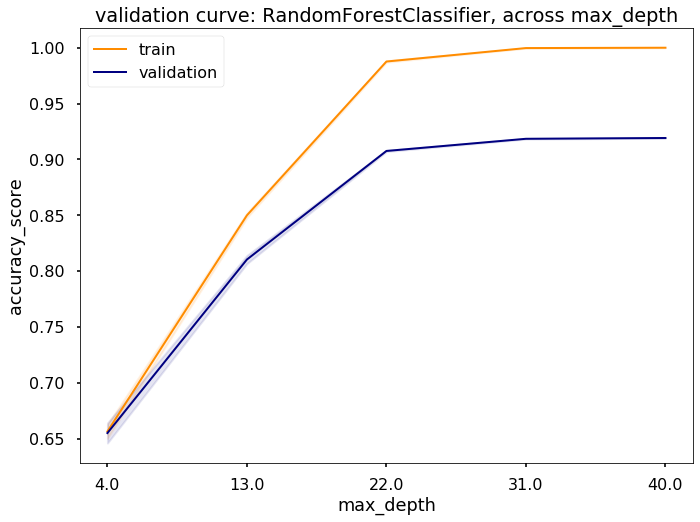

In [1027]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=X,
                        y=y,
                        param_name='max_depth',
                        param_range=np.linspace(4, 40, 5),
                        other_params={'class_weight':'balanced_subsample',
                                      'n_estimators':100},
                        score=accuracy_score)

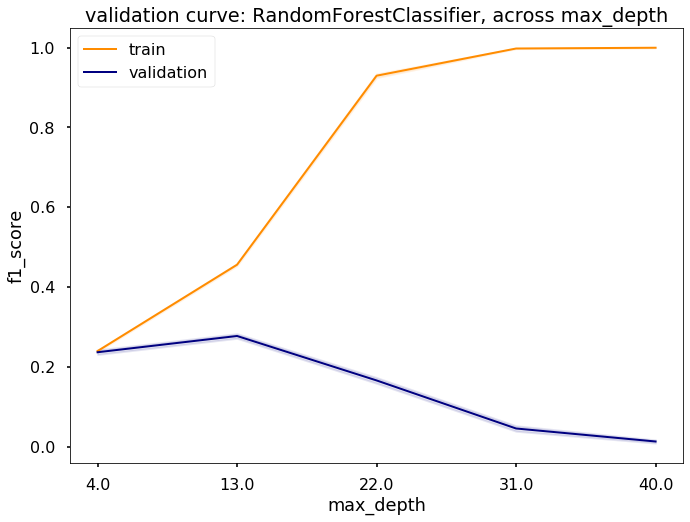

In [1028]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=X,
                        y=y,
                        param_name='max_depth',
                        param_range=np.linspace(4, 40, 5),
                        other_params={'class_weight':'balanced_subsample',
                                      'n_estimators':100},
                        score=f1_score)

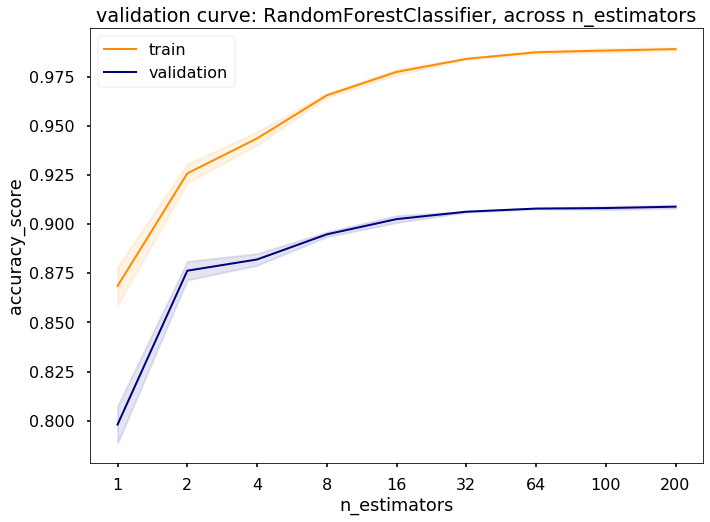

In [1030]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=X,
                        y=y,
                        param_name='n_estimators',
                        param_range=[1, 2, 4, 8, 16, 32, 64, 100, 200],
                        other_params={'class_weight':'balanced_subsample',
                                      'max_depth':22},
                        score=accuracy_score)

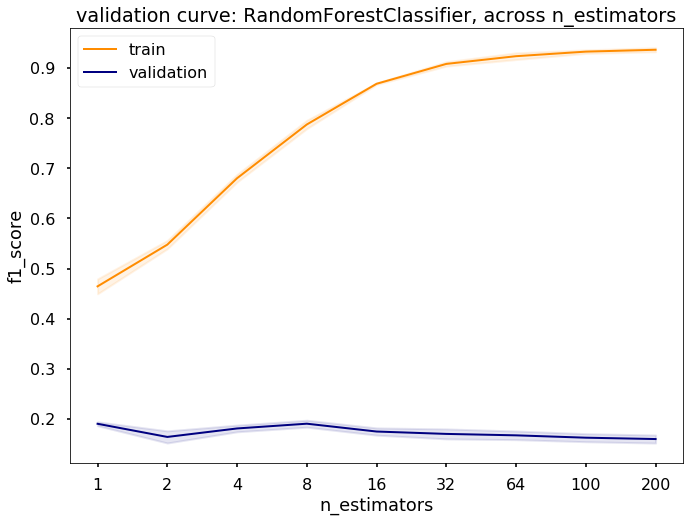

In [1031]:
curves.validation_curve(model_type=RandomForestClassifier,
                        X=X,
                        y=y,
                        param_name='n_estimators',
                        param_range=[1, 2, 4, 8, 16, 32, 64, 100, 200],
                        other_params={'class_weight':'balanced_subsample',
                                      'max_depth':22},
                        score=f1_score)

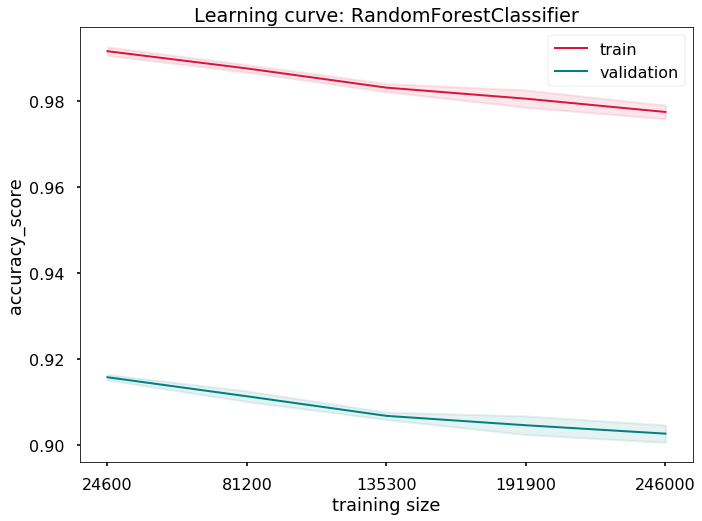

In [1033]:
curves.learning_curve(model_type=RandomForestClassifier,
                      X=X,
                      y=y,
                      model_params={'class_weight':'balanced_subsample',
                                    'n_estimators':16,
                                    "max_depth": 22},
                      score=accuracy_score)

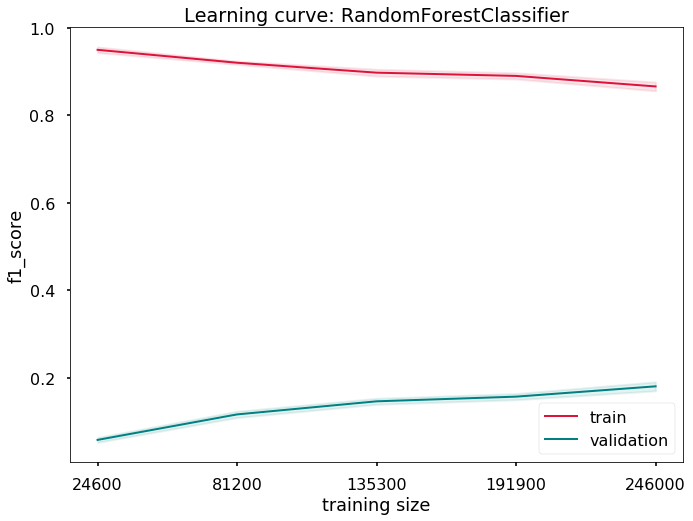

In [1034]:
curves.learning_curve(model_type=RandomForestClassifier,
                      X=X,
                      y=y,
                      model_params={'class_weight':'balanced_subsample',
                                    'n_estimators':16,
                                    "max_depth": 22},
                      score=f1_score)

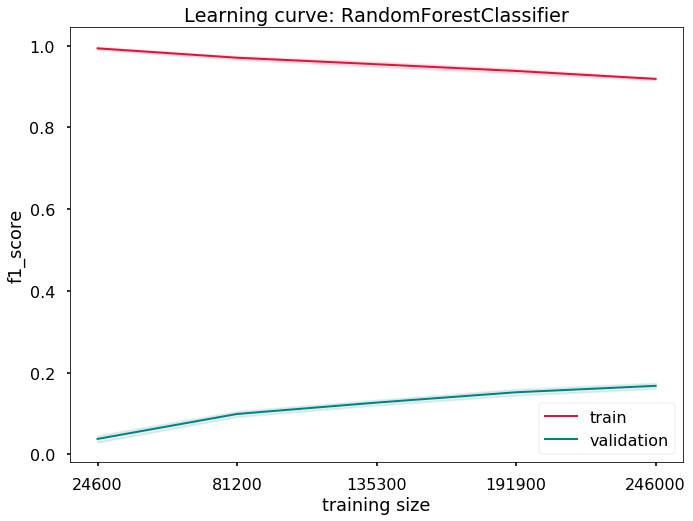

In [1035]:
curves.learning_curve(model_type=RandomForestClassifier,
                      X=X,
                      y=y,
                      model_params={'class_weight':'balanced_subsample',
                                    'n_estimators':50,
                                    "max_depth": 22},
                      score=f1_score)

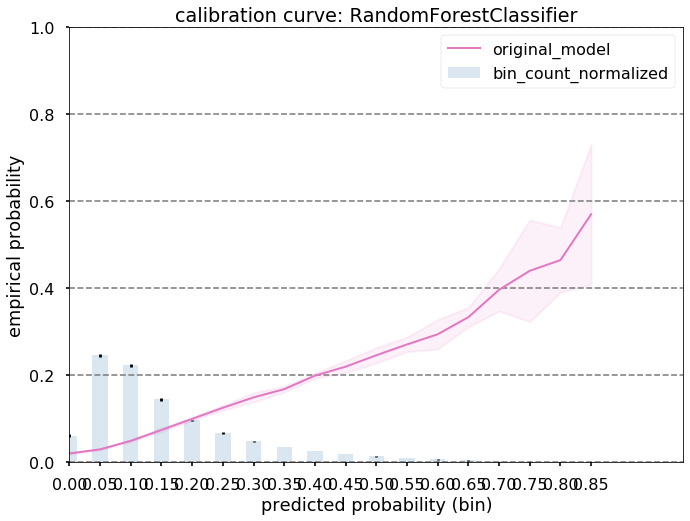

In [1037]:
curves.calibration_curve(model_type=RandomForestClassifier,
                         X=X,
                         y=y,
                         model_params={'class_weight':'balanced_subsample',
                                       'n_estimators':50,
                                       "max_depth": 22})

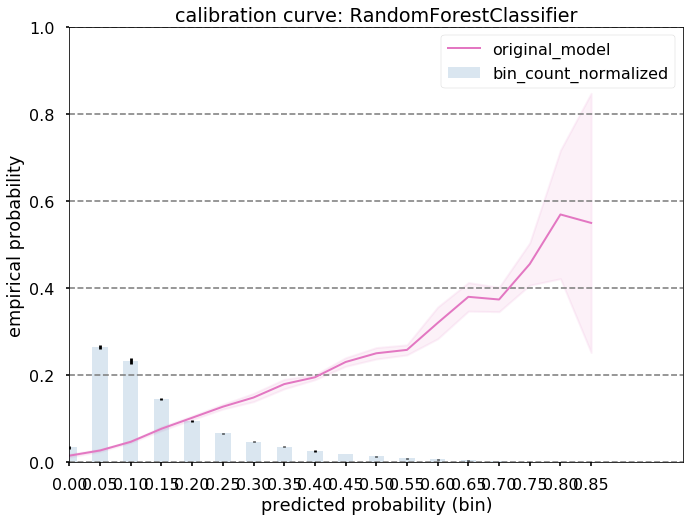

In [1038]:
curves.calibration_curve(model_type=RandomForestClassifier,
                         X=X,
                         y=y,
                         model_params={'class_weight':'balanced_subsample',
                                       'n_estimators':100,
                                       "max_depth": 22})

In [1040]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=50,
                                                                  max_depth =  22,
                                                                  class_weight='balanced_subsample'),
                                 X=X,
                                 y=y,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score],
                                 random_state=0)

In [1041]:
results

mean       std
accuracy_score  train  0.986511  0.001092
                test   0.907515  0.000929
precision_score train  0.868775  0.010022
                test   0.306816  0.009306
recall_score    train  0.981231  0.001944
                test   0.115559  0.006159

In [1079]:
results = crossvalidate.cv_score(model_obj=RandomForestClassifier(n_estimators=50,
                                                                  max_depth =  13,
                                                                  class_weight='balanced_subsample'),
                                 X=X,
                                 y=y,
                                 score_funcs=[accuracy_score,
                                              precision_score,
                                              recall_score],
                                 random_state=0)

In [1080]:
results

mean       std
accuracy_score  train  0.848948  0.001290
                test   0.808653  0.002849
precision_score train  0.320258  0.002022
                test   0.197764  0.005230
recall_score    train  0.775969  0.001919
                test   0.448187  0.009456

In [1043]:
RFC=RandomForestClassifier(n_estimators=50,max_depth =  22,class_weight='balanced_subsample')

In [1044]:
RFC = RFC.fit(X, y)

predict= RFC.predict(X)

In [1046]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = RFC.predict_proba(X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)


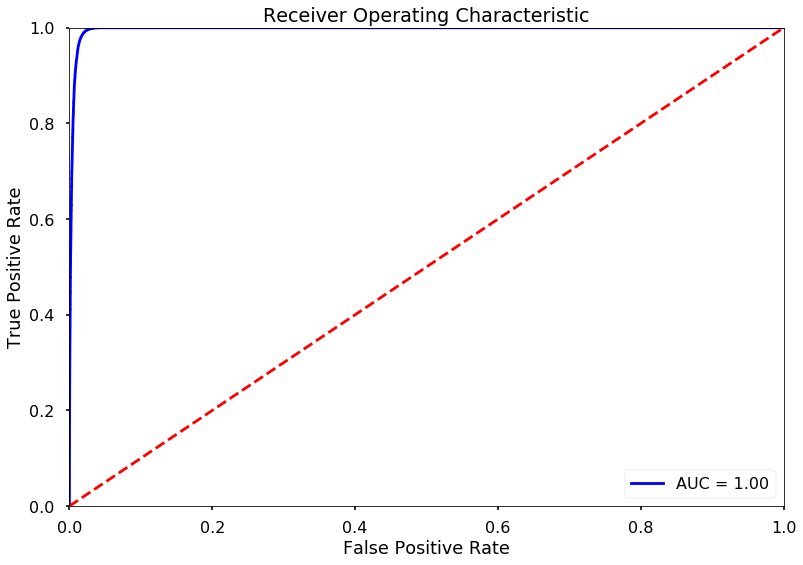

In [1047]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1064]:
testing = table_to_model[selected_features]

In [1065]:
target = table_to_model.target

In [1066]:
testing = pd.concat([testing,target],axis = 1)

In [1067]:
testing.shape

(307511, 123)

In [1068]:
test = testing.loc[final,:]

In [1069]:
get_null_stats(test)

,num_of_null,normalize_of_null


In [1070]:
X_test = test.drop(columns='target')

In [1071]:
y_test = test.target

In [1072]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = RFC.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


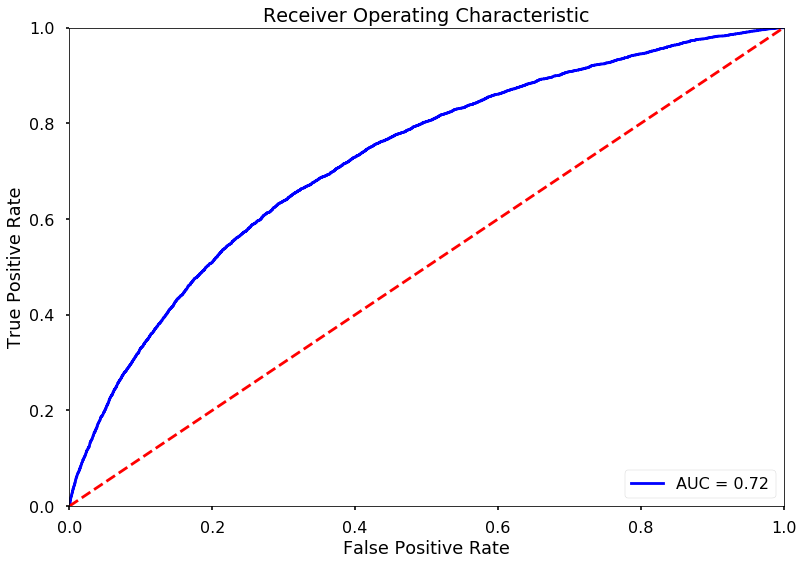

In [1073]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1076]:
RFC=RandomForestClassifier(n_estimators=50,max_depth =  13,class_weight='balanced_subsample')
RFC = RFC.fit(X, y)

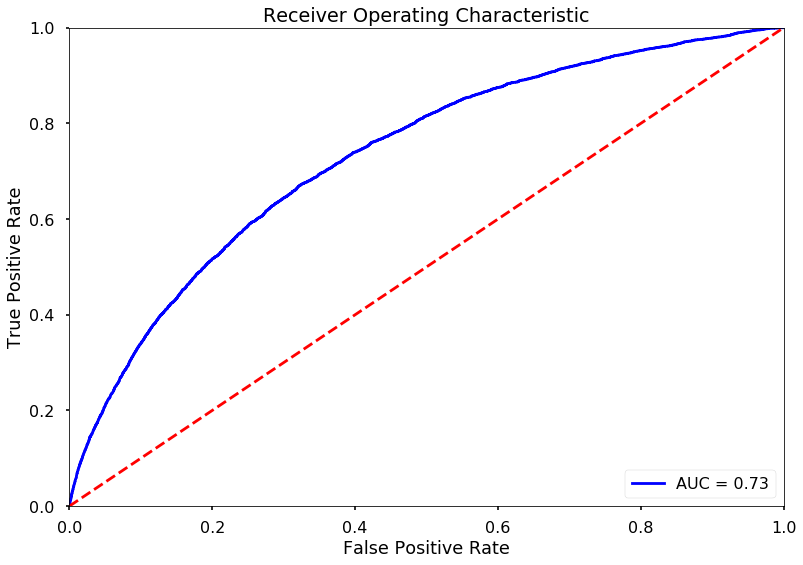

In [1077]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = RFC.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

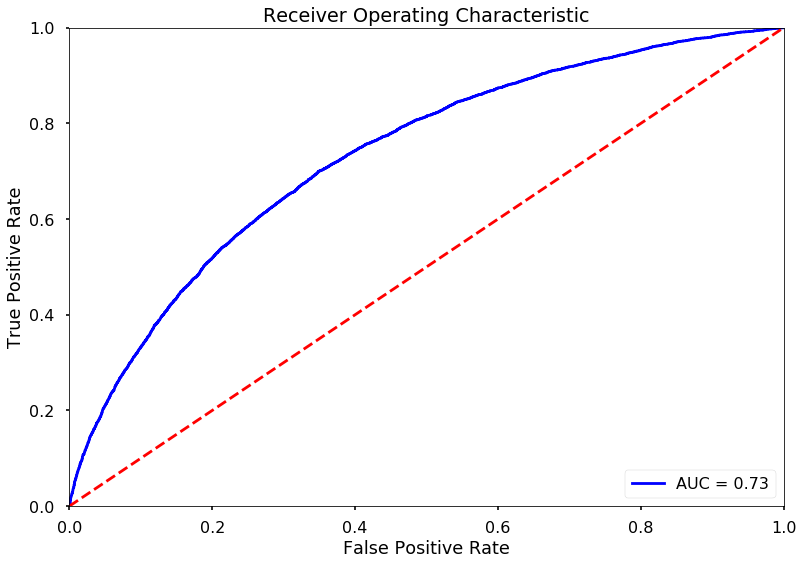

In [1078]:
RFC=RandomForestClassifier(n_estimators=50,max_depth =  8,class_weight='balanced_subsample')
RFC = RFC.fit(X, y)

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = RFC.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()